# Build a self-attention Transformer model

In this notebook, we will build the Transformer model for the classification task. The main architecture of the Transformer is derived from the paper: https://arxiv.org/pdf/1706.03762.pdf, but to be able to perform text classification we have to re-build the model a bit by applying the Max or Avg Pooling according to https://arxiv.org/pdf/1705.02364.pdf, where instead of using hidden representations we will us the last Transfomer block output.

The Transformer is solely based on the self-attention mechanism, disposing recurrent units or convolution layers at all, thanks to which that architecture is superior in terms of the prediction quality and the training time. The Transformer allows for significantly more parallelization and keeps also the ability of discerning long-term dependencies. To increase the generalization performance of the model we will use the label smoothing method.

The model is going to be trained on the clean_review column from the training dataset. In the end, the model will be evaluated on the test set to determine the generalization error.

We will perform the hyperparameter fine-tuning and visualize model's learning curves to compare the model's performance while working on different set of parameters. 

### Building and training the model

Let's start with importing all indispensable libraries.

In [1]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter

To train the model we will use the clean_review column from the training set as well as the label column.

In [2]:
# Import the dataset. Use clean_review and label columns
train_dataset = pd.read_csv('drugreview/drugreview_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'rating'])

# Change columns order
train_dataset['label'] = train_dataset.rating >= 5
train_dataset = train_dataset[['clean_review', 'label']]

In [3]:
# Depict the first 5 rows of the training set
train_dataset = train_dataset.dropna()
train_dataset.head()

,clean_review,label
1,okay anxiety gotten worse past couple years po...,True
6,reading possible effects scary medicine gave l...,True
9,clonazepam effective controlling agitation pro...,True
11,experienced effects considering anorexia nervo...,True
12,i&#039;ve gianvi months skin clear didn&#039;t...,True


To fine-tune the hyperparameters we will evaluate the model on a validation set.

In [5]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('drugreview/drugreview_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
val_dataset['label'] = val_dataset.rating >= 5
val_dataset = val_dataset[['clean_review', 'label']]

In [6]:
# Depict the first 5 rows of the validation set
val_dataset = val_dataset.dropna()
val_dataset.head()

,clean_review,label
1,4yrs having nexaplon implant mental physical h...,False
4,l5 s1 lumbar herniated disc surgery weeks surg...,True
5,far lot acne clear tea tree broke decided birt...,True
6,insulin works fine trouble pen pain pen jammed...,False
7,nexplanon option work iud painful insert pills...,True


Now we will use the BatchIterator class to preprocess the text data and generate batches.

In [7]:
batch_size = 32

In [8]:
train_iterator = BatchIterator(train_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.9,
                               use_pretrained_vectors=True, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
14773/39267 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 59
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 12312/14777 of pre-trained word vectors.
2465 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [9]:
val_iterator = BatchIterator(val_dataset, batch_size=batch_size, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.9, use_pretrained_vectors=True, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_val.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
7720/19770 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 58
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 12475/15036 of pre-trained word vectors.
2561 vectors initialized to random numbers
Weights vectors saved into glove/weights_val.npy
Batches created


Now we will check out if the batches look correctly.

In [10]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([32, 14])
target shape:  torch.Size([32])
x_lengths shape:  torch.Size([32])


In [11]:
# Extract the maximum sequence length

max_len = 0

for batches in train_iterator:
    x_lengths = batches['x_lengths']
    if max(x_lengths) > max_len:
        max_len = int(max(x_lengths))

In [12]:
print('Maximum sequence length: {}'.format(max_len))

Maximum sequence length: 60


Let's start implementing the Transformer model.

In [13]:
class MultiHeadAttention(nn.Module):
    """Implementation of the Multi-Head-Attention.
        
    Parameters
    ----------
    dmodel: int
        Dimensionality of the input embedding vector.
    heads: int
        Number of the self-attention operations to conduct in parallel. 
    """
    
    def __init__(self, dmodel, heads):
        
        super(MultiHeadAttention, self).__init__()
        
        assert dmodel % heads == 0, 'Embedding dimension is not divisible by number of heads'
            
        self.dmodel = dmodel
        self.heads = heads
        # Split dmodel (embedd dimension) into 'heads' number of chunks
        # each chunk of size key_dim will be passed to different attention head
        self.key_dim = dmodel // heads
        
        # keys, queries and values will be computed at once for all heads
        self.linear = nn.ModuleList([
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False),
            nn.Linear(self.dmodel, self.dmodel, bias=False)])
        
        self.concat = nn.Linear(self.dmodel, self.dmodel, bias=False)
        
        
    def forward(self, inputs):
        """ Perform Multi-Head-Attention.
        
        Parameters
        ----------
        inputs: torch.Tensor
            Batch of inputs - position encoded word embeddings ((batch_size, seq_length, embedding_dim)
            
        Returns
        -------
        torch.Tensor
            Multi-Head-Attention output of a shape (batch_size, seq_len, dmodel)
        """
        
        self.batch_size = inputs.size(0)
        
        assert inputs.size(2) == self.dmodel, 'Input sizes mismatch, dmodel={}, while embedd={}'\
            .format(self.dmodel, inputs.size(2))

        # Inputs shape (batch_size, seq_length, embedding_dim)        
        # Map input batch allong embedd dimension to query, key and value vectors with
        # a shape of (batch_size, heads, seq_len, key_dim (dmodel // heads)) 
        # where 'heads' dimension corresponds o different attention head
        query, key, value = [linear(x).view(self.batch_size, -1, self.heads, self.key_dim).transpose(1, 2)\
                             for linear, x in zip(self.linear, (inputs, inputs, inputs))]
        
        # Calculate the score (batch_size, heads, seq_len, seq_len)
        # for all heads at once
        score = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(self.key_dim)
        
        # Apply softmax to scores (batch_size, heads, seq_len, seq_len) 
        soft_score = F.softmax(score, dim = -1)
        
        # Multiply softmaxed score and value vector
        # value input shape (batch_size, heads, seq_len, key_dim)
        # out shape (batch_size, seq_len, dmodel (key_dim * heads))
        out = torch.matmul(soft_score, value).transpose(1, 2).contiguous()\
            .view(self.batch_size, -1, self.heads * self.key_dim)
        
        # Concatenate and linearly transform heads to the lower dimensional space
        # out shape (batch_size, seq_len, dmodel)
        out = self.concat(out)
        
        return out
        
        
class PositionalEncoding(nn.Module):
    """Implementation of the positional encoding.
    
    Parameters
    ----------
    max_len: int
        The maximum expected sequence length.
    dmodel: int
        Dimensionality of the input embedding vector.
    dropout: float
        Probability of an element of the tensor to be zeroed.
    padding_idx: int
        Index of the padding token in the vocabulary and word embedding.

    """
    
    def __init__(self, max_len, dmodel, dropout, padding_idx):
        
        super(PositionalEncoding, self).__init__()
                
        self.dropout = nn.Dropout(dropout)
        
        # Create pos_encoding, positions and dimensions matrices
        # with a shape of (max_len, dmodel)
        self.pos_encoding = torch.zeros(max_len, dmodel)
        positions = torch.repeat_interleave(torch.arange(float(max_len)).unsqueeze(1), dmodel, dim=1)
        dimensions = torch.arange(float(dmodel)).repeat(max_len, 1)
                                  
        # Calculate the encodings trigonometric function argument (max_len, dmodel)
        trig_fn_arg = positions / (torch.pow(10000, 2 * dimensions / dmodel))
               
        # Encode positions using sin function for even dimensions and
        # cos function for odd dimensions
        self.pos_encoding[:, 0::2] = torch.sin(trig_fn_arg[:, 0::2])
        self.pos_encoding[:, 1::2] = torch.cos(trig_fn_arg[:, 1::2])
        
        # Set the padding positional encoding to zero tensor
        if padding_idx:
            self.pos_encoding[padding_idx] = 0.0
        
        # Add batch dimension
        self.pos_encoding = self.pos_encoding.unsqueeze(0)
        
        
    def forward(self, embedd):
        """Apply positional encoding.
    
        Parameters
        ----------
        embedd: torch.Tensor
            Batch of word embeddings ((batch_size, seq_length, dmodel = embedding_dim))
        
        Returns
        -------
        torch.Tensor
            Sum of word embeddings and positional embeddings (batch_size, seq_length, dmodel)
        """
        
        # embedd shape (batch_size, seq_length, embedding_dim)
        # pos_encoding shape (1, max_len, dmodel = embedd_dim)
        embedd = embedd + self.pos_encoding[:, :embedd.size(1), :]
        embedd = self.dropout(embedd)
        
        # embedd shape (batch_size, seq_length, embedding_dim)
        return embedd  
    
    
class LabelSmoothingLoss(nn.Module):
    """Implementation of label smoothing with the Kullback-Leibler divergence Loss.
    
    Example:
    label_smoothing/(output_size-1) = 0.1
    confidence = 1 - 0.1 = 0.9
        
    True labels      Smoothed one-hot labels
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |1|              [0.1000, 0.9000]
        |1|    label     [0.1000, 0.9000]
        |0|  smoothing   [0.9000, 0.1000]
        |1|    ---->     [0.1000, 0.9000]
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |0|              [0.9000, 0.1000]
        |1|              [0.1000, 0.9000]
            
    Parameters
    ----------
    output_size: int
         The number of classes.
    label_smoothing: float, optional (default=0)
        The smoothing parameter. Takes the value in range [0,1].
    
    """
    
    def __init__(self, output_size, label_smoothing=0):

        super(LabelSmoothingLoss, self).__init__()
        
        self.output_size = output_size
        self.label_smoothing = label_smoothing
        self.confidence = 1 - self.label_smoothing
        
        assert label_smoothing >= 0.0 and label_smoothing <= 1.0, \
        'Label smoothing parameter takes values in the range [0, 1]'

        self.criterion = nn.KLDivLoss()
        
        
    def forward(self, pred, target):
        """Smooth the target labels and calculate the Kullback-Leibler divergence loss.
        
        Parameters
        ----------
        pred: torch.Tensor
            Batch of log-probabilities (batch_size, output_size)
        target: torch.Tensor
            Batch of target labels (batch_size, seq_length)
            
        Returns
        -------
        torch.Tensor
            The Kullback-Leibler divergence Loss.
    
        """
        # Create a Tensor of targets probabilities of a shape that equals 'pred' dimensions, filled all
        # with label_smoothing/(output_size-1) value that will correspond to the wrong label probability.
        one_hot_probs = torch.full(size=pred.size(), fill_value=self.label_smoothing/(self.output_size - 1))
        
        # Fill the tensor at positions that correspond to the true label from the target vector (0/1)
        # with the modified value of maximum probability (confidence).
        one_hot_probs.scatter_(1, target.unsqueeze(1), self.confidence)
            
        # KLDivLoss takes inputs (pred) that contain log-probs and targets given as probs (one_hot_probs).
        return self.criterion(pred, one_hot_probs)    


In [14]:
class TransformerBlock(nn.Module):
    """Implementation of single Transformer block.
    
    Transformer block structure:
    x --> Multi-Head --> Layer normalization --> Pos-Wise FFNN --> Layer normalization --> y
      |   Attention   |                       |                 |
      |_______________|                       |_________________|
     residual connection                      residual connection
    
    Parameters
    ----------
    dmodel: int
        Dimensionality of the input embedding vector.
    ffnn_hidden_size: int
        Position-Wise-Feed-Forward Neural Network hidden size.
    heads: int
        Number of the self-attention operations to conduct in parallel.
    dropout: float
        Probability of an element of the tensor to be zeroed.
    """
    
    def __init__(self, dmodel, ffnn_hidden_size, heads, dropout):
        
        super(TransformerBlock, self).__init__()
        
        self.attention = MultiHeadAttention(dmodel, heads)
        self.layer_norm1 = nn.LayerNorm(dmodel)
        self.layer_norm2 = nn.LayerNorm(dmodel)
        
        self.ffnn = nn.Sequential(
                nn.Linear(dmodel, ffnn_hidden_size),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(ffnn_hidden_size, dmodel))
        
        
    def forward(self, inputs):
        """Forward propagate through the Transformer block.

        Parameters
        ----------
        inputs: torch.Tensor
            Batch of embeddings.
            
        Returns
        -------
        torch.Tensor
            Output of the Transformer block (batch_size, seq_length, dmodel)
        """
        # Inputs shape (batch_size, seq_length, embedding_dim = dmodel)
        output = inputs + self.attention(inputs)            
        output = self.layer_norm1(output)            
        output = output + self.ffnn(output)            
        output = self.layer_norm2(output)

        # Output shape (batch_size, seq_length, dmodel)
        return output
        
        
class Transformer(nn.Module):
    """Implementation of the Transformer model for classification.
    
    Parameters
    ----------
    vocab_size: int
        The size of the vocabulary.
    dmodel: int
        Dimensionality of the embedding vector.
    max_len: int
        The maximum expected sequence length.
    padding_idx: int, optional (default=0)
        Index of the padding token in the vocabulary and word embedding.
    n_layers: int, optional (default=4)
        Number of the stacked Transformer blocks.    
    ffnn_hidden_size: int, optonal (default=dmodel * 4)
        Position-Wise-Feed-Forward Neural Network hidden size.
    heads: int, optional (default=8)
        Number of the self-attention operations to conduct in parallel.
    pooling: str, optional (default='max')
        Specify the type of pooling to use. Available options: 'max' or 'avg'.
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    """
    
    def __init__(self, vocab_size, dmodel, output_size, max_len, padding_idx=0, n_layers=4,
                 ffnn_hidden_size=None, heads=8, pooling='max', dropout=0.2):
        
        super(Transformer, self).__init__()
        
        if not ffnn_hidden_size:
            ffnn_hidden_size = dmodel * 4
            
        assert pooling == 'max' or pooling == 'avg', 'Improper pooling type was passed.'
        
        self.pooling = pooling
        self.output_size = output_size
        
        self.embedding = nn.Embedding(vocab_size, dmodel)
        
        self.pos_encoding = PositionalEncoding(max_len, dmodel, dropout, padding_idx)
        
        self.tnf_blocks = nn.ModuleList()
        
        for n in range(n_layers):
            self.tnf_blocks.append(
                TransformerBlock(dmodel, ffnn_hidden_size, heads, dropout))
            
        self.tnf_blocks = nn.Sequential(*self.tnf_blocks)
            
        self.linear = nn.Linear(dmodel, output_size)
        
        
    def forward(self, inputs, input_lengths):
        """Forward propagate through the Transformer.
        
        Parameters
        ----------
        inputs: torch.Tensor
            Batch of input sequences.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed class tensor.
        """
        self.batch_size = inputs.size(0)
        
        # Input dimensions (batch_size, seq_length, dmodel)
        output = self.embedding(inputs)
        output = self.pos_encoding(output)
        output = self.tnf_blocks(output)
        # Output dimensions (batch_size, seq_length, dmodel)
        
        if self.pooling == 'max':
            # Permute to the shape (batch_size, dmodel, seq_length)
            # Apply max-pooling, output dimensions (batch_size, dmodel)
            output = F.adaptive_max_pool1d(output.permute(0,2,1), (1,)).view(self.batch_size,-1)
        else:
            # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
            # Output shape: (batch_size, dmodel)
            output = torch.sum(output, dim=1) / input_lengths.view(-1,1).type(torch.FloatTensor) 
            
        output = self.linear(output)
        
        return F.log_softmax(output, dim=-1)
        
        
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Perform single training epoch.
        
        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.
            
        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.
            
        """
        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq, x_lengths)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.
            
        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.
            
        """
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq, x_lengths)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix
    

In [15]:
# Initialize parameters
vocab_size = len(train_iterator.word2index)
dmodel = 64
output_size = 2
padding_idx = train_iterator.word2index['<PAD>']
n_layers = 4
ffnn_hidden_size = dmodel * 2
heads = 8
pooling = 'max'
dropout = 0.5
label_smoothing = 0.1
learning_rate = 0.001
epochs = 30

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = Transformer(vocab_size, dmodel, output_size, max_len, padding_idx, n_layers,\
                    ffnn_hidden_size, heads, pooling, dropout)

# Move the model to GPU if possible
if CUDA:
    model.cuda()
    
# Add loss function    
if label_smoothing:
    loss_fn = LabelSmoothingLoss(output_size, label_smoothing)
else:
    loss_fn = nn.NLLLoss()
    
model.add_loss_fn(loss_fn)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Create the parameters dictionary and instantiate the tensorboardX SummaryWriter
params = {'batch_size': batch_size,
          'dmodel': dmodel,
          'n_layers': n_layers,
          'ffnn_hidden_size': ffnn_hidden_size,
          'heads': heads,
          'pooling': pooling,
          'dropout': dropout,
          'label_smoothing': label_smoothing,
          'learning_rate': learning_rate}

train_writer = SummaryWriter(comment=f' Training, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

val_writer = SummaryWriter(comment=f' Validation, batch_size={batch_size}, dmodel={dmodel}, n_layers={n_layers},\
ffnn_hidden_size={ffnn_hidden_size}, heads={heads}, pooling={pooling}, dropout={dropout}, \
label_smoothing={label_smoothing}, learning_rate={learning_rate}'.format(**params))

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=3)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):
    
    try:
        print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))

        train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)

        train_losses_list.append(train_losses)
        train_avg_loss_list.append(train_avg_loss)
        train_accuracy_list.append(train_accuracy)

        _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)

        eval_avg_loss_list.append(eval_avg_loss)
        eval_accuracy_list.append(eval_accuracy)
        conf_matrix_list.append(conf_matrix)

        print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
              .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))

        train_writer.add_scalar('Training loss', train_avg_loss, epoch)
        val_writer.add_scalar('Validation loss', eval_avg_loss, epoch)

        if early_stop.stop(eval_avg_loss, model, delta=0.003):
            break

    finally:
        train_writer.close()
        val_writer.close()



Start epoch [1/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1552. Accuracy: 0.733
Iteration: 200. Average training loss: 0.1445. Accuracy: 0.740
Iteration: 300. Average training loss: 0.1430. Accuracy: 0.743
Iteration: 400. Average training loss: 0.1416. Accuracy: 0.745
Iteration: 500. Average training loss: 0.1431. Accuracy: 0.745
Iteration: 600. Average training loss: 0.1328. Accuracy: 0.747
Iteration: 700. Average training loss: 0.1289. Accuracy: 0.750
Iteration: 800. Average training loss: 0.1332. Accuracy: 0.749
Iteration: 900. Average training loss: 0.1351. Accuracy: 0.749
Iteration: 1000. Average training loss: 0.1273. Accuracy: 0.750
Iteration: 1100. Average training loss: 0.1298. Accuracy: 0.751
Iteration: 1200. Average training loss: 0.1270. Accuracy: 0.752
Iteration: 1300. Average training loss: 0.1248. Accuracy: 0.754
Iteration: 1400. Average training loss: 0.1238. Accuracy: 0.755


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.1121. Accuracy: 0.79
Iteration: 200. Average evaluation loss: 0.1172. Accuracy: 0.78
Iteration: 300. Average evaluation loss: 0.1211. Accuracy: 0.78

Epoch [1/30]: Train accuracy: 0.755. Train loss: 0.1349. Evaluation accuracy: 0.778. Evaluation loss: 0.1171

Start epoch [2/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1278. Accuracy: 0.757
Iteration: 200. Average training loss: 0.1258. Accuracy: 0.759
Iteration: 300. Average training loss: 0.1244. Accuracy: 0.761
Iteration: 400. Average training loss: 0.1183. Accuracy: 0.767
Iteration: 500. Average training loss: 0.1212. Accuracy: 0.768
Iteration: 600. Average training loss: 0.1177. Accuracy: 0.770
Iteration: 700. Average training loss: 0.1162. Accuracy: 0.771
Iteration: 800. Average training loss: 0.1231. Accuracy: 0.770
Iteration: 900. Average training loss: 0.1178. Accuracy: 0.772
Iteration: 1000. Average training loss: 0.1178. Accuracy: 0.773
Iteration: 1100. Average training loss: 0.1155. Accuracy: 0.774
Iteration: 1200. Average training loss: 0.1151. Accuracy: 0.775
Iteration: 1300. Average training loss: 0.1137. Accuracy: 0.776
Iteration: 1400. Average training loss: 0.1128. Accuracy: 0.777


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.1003. Accuracy: 0.81
Iteration: 200. Average evaluation loss: 0.1066. Accuracy: 0.81
Iteration: 300. Average evaluation loss: 0.1089. Accuracy: 0.80

Epoch [2/30]: Train accuracy: 0.778. Train loss: 0.1190. Evaluation accuracy: 0.803. Evaluation loss: 0.1053

Start epoch [3/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1161. Accuracy: 0.777
Iteration: 200. Average training loss: 0.1153. Accuracy: 0.783
Iteration: 300. Average training loss: 0.1116. Accuracy: 0.787
Iteration: 400. Average training loss: 0.1102. Accuracy: 0.790
Iteration: 500. Average training loss: 0.1108. Accuracy: 0.791
Iteration: 600. Average training loss: 0.1096. Accuracy: 0.792
Iteration: 700. Average training loss: 0.1072. Accuracy: 0.795
Iteration: 800. Average training loss: 0.1137. Accuracy: 0.795
Iteration: 900. Average training loss: 0.1112. Accuracy: 0.794
Iteration: 1000. Average training loss: 0.1073. Accuracy: 0.795
Iteration: 1100. Average training loss: 0.1069. Accuracy: 0.797
Iteration: 1200. Average training loss: 0.1067. Accuracy: 0.798
Iteration: 1300. Average training loss: 0.1055. Accuracy: 0.798
Iteration: 1400. Average training loss: 0.1075. Accuracy: 0.798


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0971. Accuracy: 0.82
Iteration: 200. Average evaluation loss: 0.1032. Accuracy: 0.81
Iteration: 300. Average evaluation loss: 0.1056. Accuracy: 0.81

Epoch [3/30]: Train accuracy: 0.798. Train loss: 0.1098. Evaluation accuracy: 0.810. Evaluation loss: 0.1021

Start epoch [4/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1088. Accuracy: 0.799
Iteration: 200. Average training loss: 0.1093. Accuracy: 0.799
Iteration: 300. Average training loss: 0.1067. Accuracy: 0.799
Iteration: 400. Average training loss: 0.1066. Accuracy: 0.803
Iteration: 500. Average training loss: 0.1034. Accuracy: 0.804
Iteration: 600. Average training loss: 0.1042. Accuracy: 0.805
Iteration: 700. Average training loss: 0.1011. Accuracy: 0.806
Iteration: 800. Average training loss: 0.1088. Accuracy: 0.805
Iteration: 900. Average training loss: 0.1023. Accuracy: 0.806
Iteration: 1000. Average training loss: 0.1032. Accuracy: 0.806
Iteration: 1100. Average training loss: 0.1016. Accuracy: 0.807
Iteration: 1200. Average training loss: 0.1005. Accuracy: 0.808
Iteration: 1300. Average training loss: 0.1017. Accuracy: 0.808
Iteration: 1400. Average training loss: 0.1016. Accuracy: 0.809


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0963. Accuracy: 0.82
Iteration: 200. Average evaluation loss: 0.1021. Accuracy: 0.82
Iteration: 300. Average evaluation loss: 0.1034. Accuracy: 0.82

Epoch [4/30]: Train accuracy: 0.809. Train loss: 0.1042. Evaluation accuracy: 0.817. Evaluation loss: 0.1007

Start epoch [5/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.1036. Accuracy: 0.806
Iteration: 200. Average training loss: 0.1035. Accuracy: 0.811
Iteration: 300. Average training loss: 0.1021. Accuracy: 0.810
Iteration: 400. Average training loss: 0.1007. Accuracy: 0.813
Iteration: 500. Average training loss: 0.1000. Accuracy: 0.813
Iteration: 600. Average training loss: 0.0996. Accuracy: 0.815
Iteration: 700. Average training loss: 0.0994. Accuracy: 0.815
Iteration: 800. Average training loss: 0.1041. Accuracy: 0.815
Iteration: 900. Average training loss: 0.0984. Accuracy: 0.816
Iteration: 1000. Average training loss: 0.1014. Accuracy: 0.815
Iteration: 1100. Average training loss: 0.0983. Accuracy: 0.815
Iteration: 1200. Average training loss: 0.0958. Accuracy: 0.816
Iteration: 1300. Average training loss: 0.0992. Accuracy: 0.816
Iteration: 1400. Average training loss: 0.0990. Accuracy: 0.816


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0928. Accuracy: 0.83
Iteration: 200. Average evaluation loss: 0.0985. Accuracy: 0.82
Iteration: 300. Average evaluation loss: 0.1006. Accuracy: 0.82

Epoch [5/30]: Train accuracy: 0.816. Train loss: 0.1003. Evaluation accuracy: 0.821. Evaluation loss: 0.0973

Start epoch [6/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0972. Accuracy: 0.827
Iteration: 200. Average training loss: 0.1000. Accuracy: 0.822
Iteration: 300. Average training loss: 0.0994. Accuracy: 0.821
Iteration: 400. Average training loss: 0.0963. Accuracy: 0.822
Iteration: 500. Average training loss: 0.0968. Accuracy: 0.823
Iteration: 600. Average training loss: 0.0963. Accuracy: 0.823
Iteration: 700. Average training loss: 0.0960. Accuracy: 0.822
Iteration: 800. Average training loss: 0.1022. Accuracy: 0.821
Iteration: 900. Average training loss: 0.0978. Accuracy: 0.821
Iteration: 1000. Average training loss: 0.0975. Accuracy: 0.820
Iteration: 1100. Average training loss: 0.0945. Accuracy: 0.821
Iteration: 1200. Average training loss: 0.0913. Accuracy: 0.822
Iteration: 1300. Average training loss: 0.0947. Accuracy: 0.823
Iteration: 1400. Average training loss: 0.0960. Accuracy: 0.823


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0915. Accuracy: 0.83
Iteration: 200. Average evaluation loss: 0.0980. Accuracy: 0.83
Iteration: 300. Average evaluation loss: 0.0996. Accuracy: 0.83

Epoch [6/30]: Train accuracy: 0.823. Train loss: 0.0968. Evaluation accuracy: 0.824. Evaluation loss: 0.0966

Start epoch [7/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0985. Accuracy: 0.826
Iteration: 200. Average training loss: 0.0992. Accuracy: 0.823
Iteration: 300. Average training loss: 0.0960. Accuracy: 0.822
Iteration: 400. Average training loss: 0.0953. Accuracy: 0.824
Iteration: 500. Average training loss: 0.0920. Accuracy: 0.825
Iteration: 600. Average training loss: 0.0941. Accuracy: 0.825
Iteration: 700. Average training loss: 0.0901. Accuracy: 0.827
Iteration: 800. Average training loss: 0.0988. Accuracy: 0.826
Iteration: 900. Average training loss: 0.0938. Accuracy: 0.825
Iteration: 1000. Average training loss: 0.0929. Accuracy: 0.825
Iteration: 1100. Average training loss: 0.0896. Accuracy: 0.827
Iteration: 1200. Average training loss: 0.0888. Accuracy: 0.828
Iteration: 1300. Average training loss: 0.0911. Accuracy: 0.827
Iteration: 1400. Average training loss: 0.0932. Accuracy: 0.828


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0910. Accuracy: 0.83
Iteration: 200. Average evaluation loss: 0.0972. Accuracy: 0.82
Iteration: 300. Average evaluation loss: 0.0989. Accuracy: 0.82

Epoch [7/30]: Train accuracy: 0.828. Train loss: 0.0938. Evaluation accuracy: 0.820. Evaluation loss: 0.0960

Start epoch [8/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0928. Accuracy: 0.826
Iteration: 200. Average training loss: 0.0951. Accuracy: 0.829
Iteration: 300. Average training loss: 0.0929. Accuracy: 0.829
Iteration: 400. Average training loss: 0.0943. Accuracy: 0.830
Iteration: 500. Average training loss: 0.0913. Accuracy: 0.831
Iteration: 600. Average training loss: 0.0922. Accuracy: 0.832
Iteration: 700. Average training loss: 0.0897. Accuracy: 0.832
Iteration: 800. Average training loss: 0.0917. Accuracy: 0.832
Iteration: 900. Average training loss: 0.0888. Accuracy: 0.832
Iteration: 1000. Average training loss: 0.0929. Accuracy: 0.832
Iteration: 1100. Average training loss: 0.0883. Accuracy: 0.833
Iteration: 1200. Average training loss: 0.0877. Accuracy: 0.834
Iteration: 1300. Average training loss: 0.0921. Accuracy: 0.833
Iteration: 1400. Average training loss: 0.0901. Accuracy: 0.833


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0890. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0933. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0951. Accuracy: 0.83

Epoch [8/30]: Train accuracy: 0.833. Train loss: 0.0914. Evaluation accuracy: 0.830. Evaluation loss: 0.0929

Start epoch [9/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0898. Accuracy: 0.838
Iteration: 200. Average training loss: 0.0908. Accuracy: 0.836
Iteration: 300. Average training loss: 0.0888. Accuracy: 0.835
Iteration: 400. Average training loss: 0.0901. Accuracy: 0.837
Iteration: 500. Average training loss: 0.0876. Accuracy: 0.837
Iteration: 600. Average training loss: 0.0907. Accuracy: 0.838
Iteration: 700. Average training loss: 0.0886. Accuracy: 0.838
Iteration: 800. Average training loss: 0.0954. Accuracy: 0.837
Iteration: 900. Average training loss: 0.0892. Accuracy: 0.838
Iteration: 1000. Average training loss: 0.0899. Accuracy: 0.837
Iteration: 1100. Average training loss: 0.0860. Accuracy: 0.839
Iteration: 1200. Average training loss: 0.0830. Accuracy: 0.840
Iteration: 1300. Average training loss: 0.0904. Accuracy: 0.839
Iteration: 1400. Average training loss: 0.0899. Accuracy: 0.839


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0899. Accuracy: 0.83
Iteration: 200. Average evaluation loss: 0.0950. Accuracy: 0.83
Iteration: 300. Average evaluation loss: 0.0961. Accuracy: 0.82

Epoch [9/30]: Train accuracy: 0.839. Train loss: 0.0893. Evaluation accuracy: 0.823. Evaluation loss: 0.0941

Start epoch [10/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0888. Accuracy: 0.840
Iteration: 200. Average training loss: 0.0897. Accuracy: 0.837
Iteration: 300. Average training loss: 0.0899. Accuracy: 0.836
Iteration: 400. Average training loss: 0.0862. Accuracy: 0.839
Iteration: 500. Average training loss: 0.0873. Accuracy: 0.839
Iteration: 600. Average training loss: 0.0874. Accuracy: 0.839
Iteration: 700. Average training loss: 0.0851. Accuracy: 0.840
Iteration: 800. Average training loss: 0.0923. Accuracy: 0.839
Iteration: 900. Average training loss: 0.0877. Accuracy: 0.839
Iteration: 1000. Average training loss: 0.0904. Accuracy: 0.839
Iteration: 1100. Average training loss: 0.0839. Accuracy: 0.840
Iteration: 1200. Average training loss: 0.0823. Accuracy: 0.840
Iteration: 1300. Average training loss: 0.0879. Accuracy: 0.840
Iteration: 1400. Average training loss: 0.0891. Accuracy: 0.840


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0874. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0916. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0939. Accuracy: 0.84

Epoch [10/30]: Train accuracy: 0.840. Train loss: 0.0877. Evaluation accuracy: 0.834. Evaluation loss: 0.0913

Start epoch [11/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0889. Accuracy: 0.842
Iteration: 200. Average training loss: 0.0880. Accuracy: 0.843
Iteration: 300. Average training loss: 0.0862. Accuracy: 0.844
Iteration: 400. Average training loss: 0.0857. Accuracy: 0.845
Iteration: 500. Average training loss: 0.0839. Accuracy: 0.846
Iteration: 600. Average training loss: 0.0850. Accuracy: 0.847
Iteration: 700. Average training loss: 0.0833. Accuracy: 0.848
Iteration: 800. Average training loss: 0.0895. Accuracy: 0.847
Iteration: 900. Average training loss: 0.0861. Accuracy: 0.846
Iteration: 1000. Average training loss: 0.0870. Accuracy: 0.846
Iteration: 1100. Average training loss: 0.0829. Accuracy: 0.847
Iteration: 1200. Average training loss: 0.0797. Accuracy: 0.848
Iteration: 1300. Average training loss: 0.0876. Accuracy: 0.848
Iteration: 1400. Average training loss: 0.0873. Accuracy: 0.847


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0879. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0927. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0938. Accuracy: 0.84

Epoch [11/30]: Train accuracy: 0.847. Train loss: 0.0858. Evaluation accuracy: 0.836. Evaluation loss: 0.0916

Start epoch [12/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0832. Accuracy: 0.845
Iteration: 200. Average training loss: 0.0864. Accuracy: 0.847
Iteration: 300. Average training loss: 0.0839. Accuracy: 0.847
Iteration: 400. Average training loss: 0.0858. Accuracy: 0.847
Iteration: 500. Average training loss: 0.0836. Accuracy: 0.845
Iteration: 600. Average training loss: 0.0827. Accuracy: 0.847
Iteration: 700. Average training loss: 0.0824. Accuracy: 0.847
Iteration: 800. Average training loss: 0.0873. Accuracy: 0.847
Iteration: 900. Average training loss: 0.0849. Accuracy: 0.847
Iteration: 1000. Average training loss: 0.0875. Accuracy: 0.846
Iteration: 1100. Average training loss: 0.0798. Accuracy: 0.847
Iteration: 1200. Average training loss: 0.0794. Accuracy: 0.848
Iteration: 1300. Average training loss: 0.0853. Accuracy: 0.848
Iteration: 1400. Average training loss: 0.0856. Accuracy: 0.848


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0875. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0915. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0930. Accuracy: 0.84

Epoch [12/30]: Train accuracy: 0.847. Train loss: 0.0841. Evaluation accuracy: 0.833. Evaluation loss: 0.0909

Start epoch [13/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0846. Accuracy: 0.852
Iteration: 200. Average training loss: 0.0838. Accuracy: 0.852
Iteration: 300. Average training loss: 0.0849. Accuracy: 0.850
Iteration: 400. Average training loss: 0.0844. Accuracy: 0.849
Iteration: 500. Average training loss: 0.0818. Accuracy: 0.850
Iteration: 600. Average training loss: 0.0796. Accuracy: 0.851
Iteration: 700. Average training loss: 0.0799. Accuracy: 0.851
Iteration: 800. Average training loss: 0.0863. Accuracy: 0.851
Iteration: 900. Average training loss: 0.0816. Accuracy: 0.851
Iteration: 1000. Average training loss: 0.0863. Accuracy: 0.850
Iteration: 1100. Average training loss: 0.0795. Accuracy: 0.851
Iteration: 1200. Average training loss: 0.0779. Accuracy: 0.852
Iteration: 1300. Average training loss: 0.0813. Accuracy: 0.853
Iteration: 1400. Average training loss: 0.0871. Accuracy: 0.852


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0876. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0914. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0937. Accuracy: 0.84

Epoch [13/30]: Train accuracy: 0.852. Train loss: 0.0827. Evaluation accuracy: 0.836. Evaluation loss: 0.0911

Start epoch [14/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0822. Accuracy: 0.853
Iteration: 200. Average training loss: 0.0811. Accuracy: 0.858
Iteration: 300. Average training loss: 0.0806. Accuracy: 0.856
Iteration: 400. Average training loss: 0.0805. Accuracy: 0.856
Iteration: 500. Average training loss: 0.0784. Accuracy: 0.857
Iteration: 600. Average training loss: 0.0822. Accuracy: 0.856
Iteration: 700. Average training loss: 0.0810. Accuracy: 0.855
Iteration: 800. Average training loss: 0.0860. Accuracy: 0.855
Iteration: 900. Average training loss: 0.0816. Accuracy: 0.855
Iteration: 1000. Average training loss: 0.0838. Accuracy: 0.854
Iteration: 1100. Average training loss: 0.0776. Accuracy: 0.855
Iteration: 1200. Average training loss: 0.0761. Accuracy: 0.856
Iteration: 1300. Average training loss: 0.0809. Accuracy: 0.855
Iteration: 1400. Average training loss: 0.0840. Accuracy: 0.855


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0881. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0924. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0948. Accuracy: 0.83

Epoch [14/30]: Train accuracy: 0.855. Train loss: 0.0811. Evaluation accuracy: 0.833. Evaluation loss: 0.0921

Start epoch [15/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0805. Accuracy: 0.853
Iteration: 200. Average training loss: 0.0816. Accuracy: 0.855
Iteration: 300. Average training loss: 0.0807. Accuracy: 0.854
Iteration: 400. Average training loss: 0.0802. Accuracy: 0.853
Iteration: 500. Average training loss: 0.0786. Accuracy: 0.855
Iteration: 600. Average training loss: 0.0761. Accuracy: 0.856
Iteration: 700. Average training loss: 0.0791. Accuracy: 0.856
Iteration: 800. Average training loss: 0.0849. Accuracy: 0.856
Iteration: 900. Average training loss: 0.0768. Accuracy: 0.857
Iteration: 1000. Average training loss: 0.0845. Accuracy: 0.856
Iteration: 1100. Average training loss: 0.0783. Accuracy: 0.856
Iteration: 1200. Average training loss: 0.0748. Accuracy: 0.857
Iteration: 1300. Average training loss: 0.0807. Accuracy: 0.856
Iteration: 1400. Average training loss: 0.0805. Accuracy: 0.856


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0874. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0914. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0941. Accuracy: 0.83

Epoch [15/30]: Train accuracy: 0.856. Train loss: 0.0797. Evaluation accuracy: 0.832. Evaluation loss: 0.0914

Start epoch [16/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0785. Accuracy: 0.863
Iteration: 200. Average training loss: 0.0818. Accuracy: 0.861
Iteration: 300. Average training loss: 0.0784. Accuracy: 0.860
Iteration: 400. Average training loss: 0.0794. Accuracy: 0.860
Iteration: 500. Average training loss: 0.0752. Accuracy: 0.861
Iteration: 600. Average training loss: 0.0771. Accuracy: 0.861
Iteration: 700. Average training loss: 0.0770. Accuracy: 0.862
Iteration: 800. Average training loss: 0.0831. Accuracy: 0.861
Iteration: 900. Average training loss: 0.0746. Accuracy: 0.862
Iteration: 1000. Average training loss: 0.0806. Accuracy: 0.861
Iteration: 1100. Average training loss: 0.0768. Accuracy: 0.861
Iteration: 1200. Average training loss: 0.0733. Accuracy: 0.862
Iteration: 1300. Average training loss: 0.0761. Accuracy: 0.862
Iteration: 1400. Average training loss: 0.0803. Accuracy: 0.862


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0871. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0903. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0934. Accuracy: 0.84

Epoch [16/30]: Train accuracy: 0.862. Train loss: 0.0780. Evaluation accuracy: 0.836. Evaluation loss: 0.0906

Start epoch [17/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0796. Accuracy: 0.858
Iteration: 200. Average training loss: 0.0785. Accuracy: 0.859
Iteration: 300. Average training loss: 0.0804. Accuracy: 0.858
Iteration: 400. Average training loss: 0.0805. Accuracy: 0.858
Iteration: 500. Average training loss: 0.0745. Accuracy: 0.860
Iteration: 600. Average training loss: 0.0755. Accuracy: 0.861
Iteration: 700. Average training loss: 0.0771. Accuracy: 0.861
Iteration: 800. Average training loss: 0.0821. Accuracy: 0.861
Iteration: 900. Average training loss: 0.0795. Accuracy: 0.860
Iteration: 1000. Average training loss: 0.0789. Accuracy: 0.859
Iteration: 1100. Average training loss: 0.0736. Accuracy: 0.860
Iteration: 1200. Average training loss: 0.0732. Accuracy: 0.861
Iteration: 1300. Average training loss: 0.0756. Accuracy: 0.861
Iteration: 1400. Average training loss: 0.0796. Accuracy: 0.860


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0883. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0922. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0947. Accuracy: 0.84

Epoch [17/30]: Train accuracy: 0.860. Train loss: 0.0777. Evaluation accuracy: 0.834. Evaluation loss: 0.0922

Start epoch [18/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0777. Accuracy: 0.861
Iteration: 200. Average training loss: 0.0778. Accuracy: 0.863
Iteration: 300. Average training loss: 0.0777. Accuracy: 0.862
Iteration: 400. Average training loss: 0.0771. Accuracy: 0.862
Iteration: 500. Average training loss: 0.0767. Accuracy: 0.862
Iteration: 600. Average training loss: 0.0760. Accuracy: 0.862
Iteration: 700. Average training loss: 0.0771. Accuracy: 0.862
Iteration: 800. Average training loss: 0.0809. Accuracy: 0.861
Iteration: 900. Average training loss: 0.0746. Accuracy: 0.862
Iteration: 1000. Average training loss: 0.0790. Accuracy: 0.861
Iteration: 1100. Average training loss: 0.0712. Accuracy: 0.862
Iteration: 1200. Average training loss: 0.0728. Accuracy: 0.863
Iteration: 1300. Average training loss: 0.0768. Accuracy: 0.863
Iteration: 1400. Average training loss: 0.0803. Accuracy: 0.862


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0890. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0928. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0946. Accuracy: 0.84

Epoch [18/30]: Train accuracy: 0.862. Train loss: 0.0768. Evaluation accuracy: 0.835. Evaluation loss: 0.0925

Start epoch [19/30]


Training:   0%|          | 0/1415 [00:00<?, ?it/s]

Iteration: 100. Average training loss: 0.0771. Accuracy: 0.863
Iteration: 200. Average training loss: 0.0774. Accuracy: 0.866
Iteration: 300. Average training loss: 0.0760. Accuracy: 0.864
Iteration: 400. Average training loss: 0.0760. Accuracy: 0.866
Iteration: 500. Average training loss: 0.0754. Accuracy: 0.865
Iteration: 600. Average training loss: 0.0743. Accuracy: 0.866
Iteration: 700. Average training loss: 0.0749. Accuracy: 0.866
Iteration: 800. Average training loss: 0.0786. Accuracy: 0.866
Iteration: 900. Average training loss: 0.0764. Accuracy: 0.865
Iteration: 1000. Average training loss: 0.0787. Accuracy: 0.865
Iteration: 1100. Average training loss: 0.0702. Accuracy: 0.866
Iteration: 1200. Average training loss: 0.0716. Accuracy: 0.866
Iteration: 1300. Average training loss: 0.0730. Accuracy: 0.867
Iteration: 1400. Average training loss: 0.0795. Accuracy: 0.866


Evaluation:   0%|          | 0/357 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0887. Accuracy: 0.84
Iteration: 200. Average evaluation loss: 0.0923. Accuracy: 0.84
Iteration: 300. Average evaluation loss: 0.0949. Accuracy: 0.84

Epoch [19/30]: Train accuracy: 0.866. Train loss: 0.0756. Evaluation accuracy: 0.835. Evaluation loss: 0.0926

Training stoped by EarlyStopping


In [24]:
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])

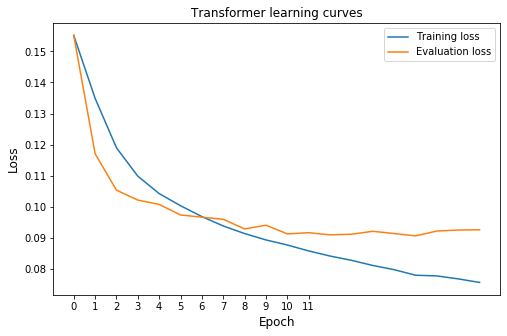

In [25]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('Transformer learning curves')
plt.xticks(ticks=range(12))
plt.legend()
plt.show()

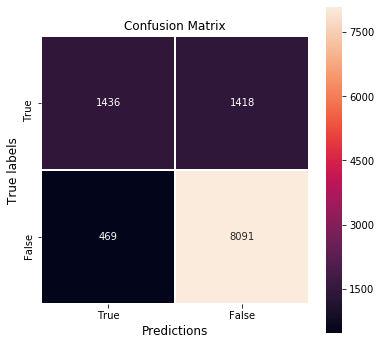

In [16]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

### The generalization error

In [17]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('drugreview/drugreview_feat_clean/test_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
test_dataset['label'] = test_dataset.rating >= 5
test_dataset = test_dataset[['clean_review', 'label']]

In [18]:
test_dataset = test_dataset.dropna()
test_dataset.head()

,clean_review,label
0,i&#039;ve tried antidepressants years citalopr...,True
1,son crohn&#039;s disease asacol complaints sho...,True
2,quick reduction symptoms,True
3,contrave combines drugs alcohol smoking opioid...,True
4,birth control cycle reading reviews type simil...,True


In [20]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=True, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights_train.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
15210/40911 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 59
Mapped words to indices
Start creating glove_word2vector dictionary
Extracted 13890/17168 of pre-trained word vectors.
3278 vectors initialized to random numbers
Weights vectors saved into glove/weights_train.npy
Batches created


In [21]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

Evaluation:   0%|          | 0/189 [00:00<?, ?it/s]

Iteration: 100. Average evaluation loss: 0.0836. Accuracy: 0.85


In [22]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.852. Test error: 0.082


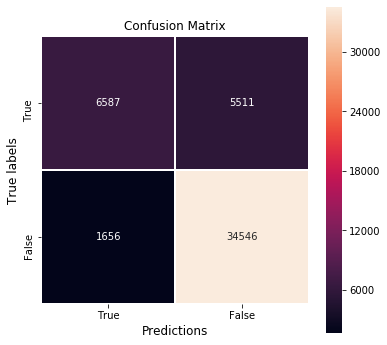

In [23]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()